In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
import math
import os
import sys
import csv
import time

data = pd.read_csv("data_OptiMinds.csv")  
# Convert fractional years to datetime to understand the data better
def fractional_year_to_date(year):
    year_int = int(year)
    remainder = year - year_int
    start_of_year = datetime.datetime(year_int, 1, 1)
    days_in_year = (datetime.datetime(year_int + 1, 1, 1) - start_of_year).days
    return start_of_year + datetime.timedelta(days=remainder * days_in_year)

# Apply conversion
data['Date'] = data['Time'].apply(fractional_year_to_date)

subset_random = data.sample(n=1000, random_state=42)
print(subset_random.head())

              Time          SN                       Date
3318   1764.202980   61.059679 1764-03-15 06:58:50.319951
32638  1845.646723   43.003447 1845-08-25 01:17:44.775877
27227  1830.616297   82.596295 1830-08-13 22:45:48.499199
24615  1823.360804    0.000000 1823-05-12 16:38:39.795686
29045  1835.666254  132.597282 1835-09-01 04:22:56.440623


In [3]:
def solar_cycle_model(t, params, num_cycles=10):
    """
    Models the solar cycles based on the given parameters, ensuring distinct parameters for each cycle.
    
    Args:
        t (ndarray): Array of time points.
        params (ndarray): Array of 3*num_cycles parameters 
                          [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        num_cycles (int): Number of solar cycles (default is 10).
     
    Returns:
        ndarray: Predicted values of x(t).
    """
    predicted_values = np.zeros_like(t)

    for k in range(num_cycles):
        T0 = params[3 * k]       # Start time of cycle k
        Ts = params[3 * k + 1]   # Rising time of cycle k
        Td = params[3 * k + 2]   # Declining time of cycle k

        # Define the range of this cycle
        cycle_mask = (t >= T0) & (t <= T0 + Ts + Td)
        t_cycle = t[cycle_mask]

        # Compute the contribution of cycle k
        if len(t_cycle) > 0:
            x_k = ((t_cycle - T0) / Ts) ** 2 * np.exp(-((t_cycle - T0) / Td) ** 2)
            predicted_values[cycle_mask] += x_k

    return predicted_values

# Loss Function: Mean Squared Error
def mse(params, t, observed_values):
    """
    Computes the Mean Squared Error (MSE) between observed data and model predictions.
    
    Args:
        params (ndarray): Model parameters [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        t (ndarray): Time points of the observations.
        observed_values (ndarray): Observed sunspot data.
    
    Returns:
        float: The MSE value.
    """
    predicted_values = solar_cycle_model(t, params)
    return np.mean((observed_values - predicted_values) ** 2)


In [4]:
def simulated_annealing(x0, T0, sigma, f, n_iter=250000, burn_in=200000, verbose=True):
    """
    Performs Simulated Annealing to optimize a given function.
    
    Args:
        x0 (ndarray): Initial parameter guess.
        T0 (float): Initial temperature.
        sigma (float): Standard deviation for the proposal distribution.
        f (function): Function to minimize.
        n_iter (int): Total number of iterations (default is 250,000).
        burn_in (int): Burn-in period (default is 200,000).
        verbose (bool): If True, prints progress during optimization.
    
    Returns:
        tuple: 
            - ndarray: Array of sampled parameter values after burn-in.
            - ndarray: Best parameter set found during the optimization.
            - float: Best loss achieved.
    """
    x = x0.copy()  # Initialize x
    T = T0         # Initialize temperature
    n_params = x0.shape[0]  # Number of parameters to be optimized

    # Mean and covariance matrix for the jump distribution
    means = np.zeros(n_params)
    cov_matrix = np.diag(np.full(n_params, sigma ** 2))  # Variance is sigma^2
    
    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    samples = np.zeros((size_out, n_params))
    
    # Track the best solution
    best_loss = float('inf')
    best_params = None

    iter_counter = 0
    initial_loss = f(x)
    if verbose:
        print("Initial loss:", initial_loss)
    
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1
        x_old = x.copy()
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        
        # Compute loss difference
        loss_old = f(x_old)
        loss_proposal = f(x_proposal)
        DeltaE = loss_proposal - loss_old
        
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal  # Accept the proposal
        else:
            x = x_old  # Reject the proposal
        
        # Track the best parameters
        if loss_proposal < best_loss:
            best_loss = loss_proposal
            best_params = x_proposal.copy()
        
        # Update temperature using exponential cooling
        T = T0 / (1 + 0.01 * iter_counter)  # Cooling schedule

        # Print progress
        if verbose and iter_counter % 10000 == 0:
            print(f"Iteration {iter_counter}, Temperature: {T:.6f}, Loss: {loss_old:.6f}")
        
        # Store parameters after burn-in
        if iter_counter > burn_in:
            samples[iter_counter - burn_in - 1, :] = x.copy()
    
    # Final output
    return samples, best_params, best_loss

In [8]:
subset_random = subset_random.sort_values(by='Date')
predicted_values = solar_cycle_model(subset_random['Time'].values, best_params)


Initial loss: 11461.329508147697
Iteration 10000, Temperature: 0.099010, Loss: 11461.329508
Iteration 20000, Temperature: 0.049751, Loss: 11461.329508
Iteration 30000, Temperature: 0.033223, Loss: 11461.329508
Iteration 40000, Temperature: 0.024938, Loss: 11461.329508
Iteration 50000, Temperature: 0.019960, Loss: 11461.329508
Iteration 60000, Temperature: 0.016639, Loss: 11461.329508
Iteration 70000, Temperature: 0.014265, Loss: 11461.329508
Iteration 80000, Temperature: 0.012484, Loss: 11461.329508
Iteration 90000, Temperature: 0.011099, Loss: 11461.329508
Iteration 100000, Temperature: 0.009990, Loss: 11461.329508
Iteration 110000, Temperature: 0.009083, Loss: 11461.329508
Iteration 120000, Temperature: 0.008326, Loss: 11461.329508
Iteration 130000, Temperature: 0.007686, Loss: 11461.329508
Iteration 140000, Temperature: 0.007138, Loss: 11461.329508
Iteration 150000, Temperature: 0.006662, Loss: 11461.329508
Iteration 160000, Temperature: 0.006246, Loss: 11461.329508
Iteration 170000

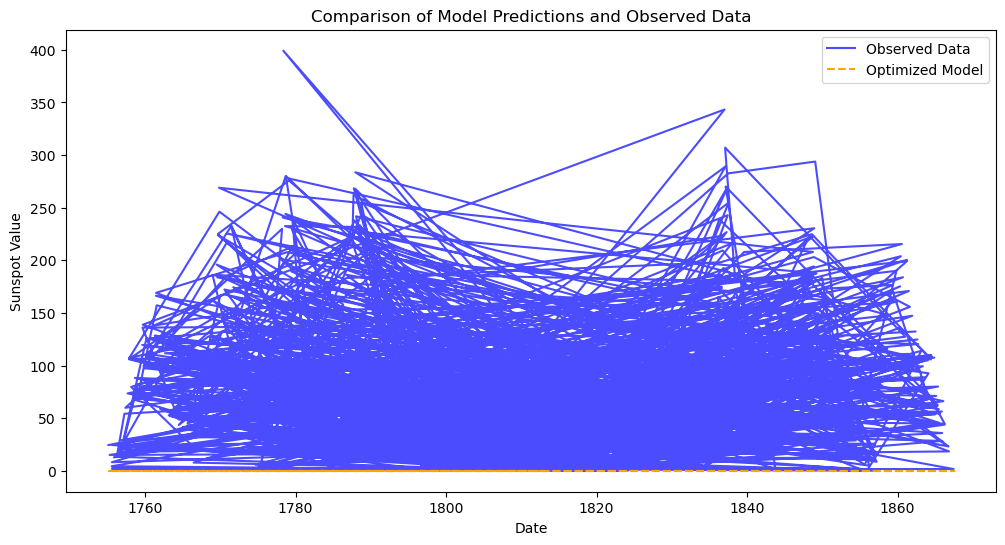

In [7]:
# Time and observed values from your subset_random
t = subset_random['Time'].values
observed_values = subset_random['SN'].values  # Use 'SN' for observed values

# Initial parameters for optimization
initial_params = np.random.uniform(low=0.1, high=5.0, size=30)  # Adjust as needed

# Hyperparameters for simulated annealing
T0 = 10
sigma = 1e-5

# Loss function
loss_function = lambda params: mse(params, t, observed_values)

# Run simulated annealing
samples, best_params, best_loss = simulated_annealing(initial_params, T0, sigma, loss_function)

# Compute predictions using the best parameters
predicted_values = solar_cycle_model(t, best_params)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(subset_random['Date'], observed_values, label="Observed Data", color="blue", alpha=0.7)
plt.plot(subset_random['Date'], predicted_values, label="Optimized Model", color="orange", linestyle="--")
plt.title("Comparison of Model Predictions and Observed Data")
plt.xlabel("Date")
plt.ylabel("Sunspot Value")
plt.legend()
plt.show()

